# Brincando com CAPM por meio de modelo dinâmico linear

obs.: Para vizualizar a notação matemática, veja o arquivo `.ipynb`.

### Resumo

A seguir é realizada uma simples análise de mercado por meio do modelo CAPM. Para efeito de demonstração, foram escolhidos os dados de retorno das ações da Amazon (listada na bolsa como AMZN) e da IBM (listada como IBM) como os a serem analisados, com bse nos valores da S&P500 (listados como SPY) como o "valor do mercado", e nos valores dos títulos do tesouro americano com taxa de maturidade constante de 1 mês como o "ativo livre de risco", todos os dados de 2000 até 2020. Primeiro, é feita uma breve explicação do modelo usado, seguido de uma discussão dos resultados e de alguns comentários quanto à implementação. Em anexo constam os códigos utilizados.

## Introdução

O objetivo é obter um modelo  que possibilite a predição da flutuação dos valores de algum ativo, segundo as flutuações do mercado. A ideia é que enquanto alguns ativos flutuam junto com o mercado, as flutuações de outros são amplificações das oscilações do mercado, enquanto as de outros ainda são diminuições dessa oscilações. Sendo capaz de quantificar isso, um investidor (por exemplo) poderia, em princípio, ser mais bem capaz de quantificar seus riscos e se proteger dos mesmos. 

Modelos clássicos tendem a ser mais simples e assumir uma relação estática, usando modelos lineares dinâmicos, podemos obter uma quantificação dinâmica, que (espera-se) corresponde melhor à realidade e leve a predições mais acuradas.

A análise aqui feita é baseada no exposto em Petris et al.(2009)(Petris, Petrone, and Campagnoli 2009), em https://blogs.rstudio.com/ai/posts/2019-06-25-dynamic_linear_models_tfprobability/ e em https://pyflux.readthedocs.io/en/latest/dyn_lin.html, com dados diários retirados por meio do yahoo finance (detalhes na seção Considerações sobre Implementação).

A seguir constam os gráficos dos retornos da IBM, seguidos pelos da Amazon (mostrados junto aos valores da SP500 e dos títulos do tesouro, para efeito de comparação):

![Retornos IBM](retornos_IBM.png)


![Retornos Amzon](retornos_Amazon.png)

### Metodologia

O CAPM é um modelo usado para determinar uma taxa de retorno apropriada sobre um ativo. Como modelo, recebeu diversas críticas, mas continua sendo visto como útil mesmo que de forma aproximada como uma "medida crua". Em resumo, esse modelo leva em conta o chamado _risco sistemático_ (usualmente denotado $\beta$), que é o _risco_ associado ao mercado. Assim, segundo o modelo, tem-se que para o retorno de um ativo, 

* $\beta = 1$ indica que ele flutua exatamente com o mercado (seu valor sobe ou decresce na medida que o do mercado sobe ou decresce);
* $\beta > 1$ indica que mudanças no mercado são amplificadas;
* $\beta < 1$ indica que mudanças no mercado são diminuidas.

Assim, o valor esperado do ativo ($E(R_a)$) é dado pelo retorno esperado do mercado $R_m$ (de _risk of market_) escalado por $\beta$, a menos de um "valor basal" $R_f$ (de _risk free_), dado por um "ativo livre de riscos". Isto é,  $E(R_a)$ é dado por $R_f$ mais $\beta$ vezes o "prêmio do mercado" $R_m + R_f$, e temos 
$$
E(R_a) = R_f + \beta(R_m + R_f).
$$ 

Para mais detalhes sobre CAPM, veja (por exemplo) Sharpe, William F. (1964). "Capital asset prices: A theory of market equilibrium under conditions of risk".

Note que o modelo dado pelo CAPM é basicamente um modelo de regressão linear, do qual se poderia obter um $\beta$ fixo. Mas pode não ser razoável assumir que a relação de um ativo com o mercado é fixa (por exemplo, companhias podem se tornar mais inovadoras ou conservadoras com uma nova gestão, podem ocorrer desestabilizações no preço de um produto devido à aparição de competidores, à quebra de monopólios por ação governamental, etc.). Dessa forma, modelos dinâmicos lineares podem ser mais adequados.

### O modelo

Os dados são modelados por meio de um modelo dinâmico linear. Modelos dinâmicos lineares no geral são do tipo

$$
\begin{split}
    y_t & = F_t'\theta_t + \epsilon_t \\
    \theta_t & = G_t \theta_{t-1} + \nu_t
\end{split}
$$

onde $\epsilon_t$ e $\nu_t$ são variáveis aleatórias e $t \in \{1, ..., T\}$. Aqui, assumiremos que $\epsilon_t \sim N(0,V_t)$ e $\nu_t \sim N(0, W_t)$.

Agora, seja um modelo de regressão linear simples, com intercepto $\alpha$:

$$
y_t = \beta x_t + \alpha + \nu_t, \nu_t \sim N(0,v)
$$

Assumindo que $\alpha$ e $\beta$ podem variar no tempo segundo um passeio aleatório, temos

$$
\begin{split}
    y_t &= \beta_t x_t + \alpha_t + \nu_t, \nu_t \sim N(0,v) \\
    \alpha_t &= \alpha_{t-1} + w_{1t} \sim N(0,W_{1t})\\
    \beta_t &= \beta_{t-1} + w_{2t} \sim N(0,W_{2t})\\
\end{split}
$$

ou, equivalentemente:
$$
\begin{split}
    y_t &= F_t'\theta_t + \nu_t, \nu_t \sim N(0,v) \\
    \theta_t &= G\theta_{t-1} + w_t, w_t \sim N(0, W)
\end{split}
$$

onde $\theta = (\beta_t\; \alpha_t)'$, $F_t' = (1\; x_t)$, $G = I_2$ e $W$ é a matriz de covâriancias $W = \begin{pmatrix} \omega_{1t} & 0 \\ 0 & \omega_{2t} \end{pmatrix}$.

### Resultados

Após rodar o MCMC, em que foram usados com 1000 simulações, obtém-se os seguintes resultados para o IBM:


![Model fit IBM](model_fit_IBM.png)

No gráfico na primeira linha podemos ver a comparação dos valores originais da série, com os obtidos pela suavização: obtém-se uma série com forma similar, mas menores amplitudes, como esperado.

Na segunda e terceira linhas vemos os valores simulados para os parâmetros. O intercepto permanece essencialmente constante e próximo de 0 no intervalo considerado, mas o $\beta$ (denotado no gráfico como "Beta SP500") oscila aproximadamente entre 0.6 e 1.2, estando na maior parte do tempo próximo de 1.0. Isso indica que as ações da IBM oscilam aproximadamente de acordo com o mercado, com as tendências para amplificá-lo ou diminui-lo tendendo a se cancelar ao longo do tempo, no intervalo considerado.

No caso da Amazon, os resultados obtidos (aplicado o mesmo método que à IBM) são os seguintes:


![Model fit Amazon](model_fit_Amazon.png)

No caso da Amazon, os resultados são distintamentes diferentes (vide gráficos acima). Enquanto o intercepto permanece essencialmente constante, próximo de 0, o $\beta$ oscila aproximadamente entre 0.7 e 2.5, permanecendo a maior parte do tempo acima de 1. Isso indica que, no intervalo considerado, as ações da Amazon tendem a amplificar o efeito do mercado, por vezes amplificando grandemente, apesar de no passado próximo (em 2020) ter se mostrado um investimento conservador. Uma possível pergunta é se isso representa uma anomalia devido à pandemia do COVID-19. Vale observar, no entanto, que a diferença de comportamento de $\beta$ para 2020 foi muito menor do que o observado no caso da Amazon.

#### Predição

Os resultados obtidos nos permite obter uma previsão segundo o modelo CAPM, com intervalo de credibilidade. No caso da IBM, usando apenas os 100 últimos valores, podemos realizar uma predição de $h = 20$ valores a frente. Para tanto, seria preciso ter também uma predição do desempenho do mercado (do S&P500), o que não fizemos (mas que poderia ser feito facilmente, por exemplo, com um modelo ARMA). Mas, a título de exemplo, mostramos as predições realizadas repetindo os últimos $h$ valores de S&P500.

![Predict IBM](predict_IBM.png)

### Considerações de implementação

#### Dificuldades de implementação e opções de biblioteca

Aqui foi mostrado os resultados obtidos por uma implementação simples, baseado na biblioteca python _pyflux_. No entanto, vale notar que existem outras, tanto em python como em outras linguagens. Para o desenvolvimento de uma aplicação comercial ou, mesmo que não comercial, de uma aplicação mais séria em certo sentido, é importante fazer uso de códigos bem mantidos, computacionalmente eficientes, de preferência estáveis, bem documentados e que permitam a escrita de código mais legível para possíveis colaboradores. 

Assim, o presente autor passou um tempo (provavelmente, mais do que devia) pesquisando, testando e tentando utilizar algumas dessas bibliotecas. No final, aqui foi utilizado o _pyflux_, que se mostrou a de utilização mais simples e ágil, mas essa biblioteca já não se encontra mais em ativo desenvolvimento e não pode se esperar muita agilidade na correção de _bugs_, nem como adições de novas funcionalidades.

Uma biblioteca que vem sendo bem desenvolvida recentemente é a _tensorflow-probability_, baseada no _tensorflow_. Além de outras linguagens, essa biblioteca pode ser utilizada do python e do R. No entanto, apesar do código eficiente, e na maior parte bem documentado, ele ainda não é estável: códigos escritos na versão atual podem não funcionar mais na versão do próximo mês, assim como a "documentação informal", na forma de artigos e tutoriais, podem deixar de serem válidas rapidamente. O _tensorflow_, assim como o _tensorflow-probability_ é uma biblioteca (que está mais para um _framework_) poderosa (oferece prontas, por exemplo, implementações eficientes e práticas de Monte Carlo Hamiltoniano e de Inferência Variacional), e que merece atenção para trabalhos futuros, mas é preciso tomar cuidado com sua base ainda pouco estável (em particular o _tensorflow_probability_, embora o _tensorflow_ já seja mais estável).

Ainda outra opção é a biblioteca _dlm_, disponível para R. Essa compartilha de qualidades e defeitos do _pyflux_, sendo uma biblioteca de fácil utilização, que oferece muitas funcionalidades, mas não todas, ou ao menos não da forma ideal. Assim como o _pyflux_, a _dlm_ não é especialmente eficiente do ponto de vista computacional, o que é um gargalo para séries temporais mais longas. Diferente do _pyflux_ (e também do _tensorflow_), contudo, apesar de ter seu código-fonte aberto, _dlm_ não está (até onde o presente autor saiba) disponível em repositório aberto, o que torna altamente improvável que melhorado no futuro.

Algo sobre o que o presente autor não pesquisou a fundo, mas vale a pena pesquisar, é a presença de bibliotecas de séries temporais em Julia. Julia tem se mostrado cada vez mais a linguagem mais adequada para (entre outras coisas) computação científica, apresentando qualidades superiores às de _python_ e de _R_, por exemplo. Contudo, tendo uma comunidade ainda nova, espera-se que o que há sobre séries temporais em julia esteja ainda em fases iniciais de desenvolvimento.

### Apêndice - Códigos

#### Considerações de implementação

##### Dificuldades de implementação e opções de biblioteca

Aqui foi mostrado os resultados obtidos por uma implementação simples, baseado na biblioteca python _pyflux_. No entanto, vale notar que existem outras, tanto em python como em outras linguagens. Para o desenvolvimento de uma aplicação comercial ou, mesmo que não comercial, de uma aplicação mais séria em certo sentido, é importante fazer uso de códigos bem mantidos, computacionalmente eficientes, de preferência estáveis, bem documentados e que permitam a escrita de código mais legível para possíveis colaboradores. 

Assim, o presente autor passou um tempo (provavelmente, mais do que devia) pesquisando, testando e tentando utilizar algumas dessas bibliotecas. No final, aqui foi utilizado o _pyflux_, que se mostrou a de utilização mais simples e ágil, mas essa biblioteca já não se encontra mais em ativo desenvolvimento e não pode se esperar muita agilidade na correção de _bugs_, nem como adições de novas funcionalidades.

Uma biblioteca que vem sendo bem desenvolvida recentemente é a _tensorflow-probability_, baseada no _tensorflow_. Além de outras linguagens, essa biblioteca pode ser utilizada do python e do R. No entanto, apesar do código eficiente, e na maior parte bem documentado, ele ainda não é estável: códigos escritos na versão atual podem não funcionar mais na versão do próximo mês, assim como a "documentação informal", na forma de artigos e tutoriais, podem deixar de serem válidas rapidamente. O _tensorflow_, assim como o _tensorflow-probability_ é uma biblioteca (que está mais para um _framework_) poderosa (oferece prontas, por exemplo, implementações eficientes e práticas de Monte Carlo Hamiltoniano e de Inferência Variacional), e que merece atenção para trabalhos futuros, mas é preciso tomar cuidado com sua base ainda pouco estável (em particular o _tensorflow_probability_, embora o _tensorflow_ já seja mais estável).

Ainda outra opção é a biblioteca _dlm_, disponível para R. Essa compartilha de qualidades e defeitos do _pyflux_, sendo uma biblioteca de fácil utilização, que oferece muitas funcionalidades, mas não todas, ou ao menos não da forma ideal. Assim como o _pyflux_, a _dlm_ não é especialmente eficiente do ponto de vista computacional, o que é um gargalo para séries temporais mais longas. Diferente do _pyflux_ (e também do _tensorflow_), contudo, apesar de ter seu código-fonte aberto, _dlm_ não está (até onde o presente autor saiba) disponível em repositório aberto, o que torna altamente improvável que melhorado no futuro.

Algo sobre o que o presente autor não pesquisou a fundo, mas vale a pena pesquisar, é a presença de bibliotecas de séries temporais em Julia. Julia tem se mostrado cada vez mais a linguagem mais adequada para (entre outras coisas) computação científica, apresentando qualidades superiores às de _python_ e de _R_, por exemplo. Contudo, tendo uma comunidade ainda nova, espera-se que o que há sobre séries temporais em julia esteja ainda em fases iniciais de desenvolvimento.

#### Breve descrição do código

O que o código faz, resumidamente, é

* Obter os dados (por meio do _DataReader_, do pacote _pandas_datareader_;
* Depois de preparados os dados, definir e treinar o modelo com pyfluxf.DynReg (no caso, usamos os _priors_ pouco informativos padrão do _pyflux_), e model.fit;
* Por fim, se o _fit_ foi feito como MCMC (o que foi, no caso), pode-se obter estatísticas do resultado, assim como realizar amostragens e predições no modelo.

O código para o caso a IBM está a seguir:

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pyflux as pf
from matplotlib import pyplot as plt
from pandas_datareader import DataReader
from datetime import datetime

In [10]:
start_year = 2016
end_year   = 2020
company = 'IBM'

# Get Amazon returns data
a = DataReader(company,  'yahoo', datetime(start_year,1,1), datetime(end_year,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = [f"{company} Returns"]

In [11]:
# Get S&P500 returns data - this will stand as "the market"
spy = DataReader('SPY',  'yahoo', datetime(start_year,1,1), datetime(end_year,6,1))
spy_returns = pd.DataFrame(np.diff(np.log(spy['Adj Close'].values)))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

In [12]:
# Get 1-month treasure constant maturity rate - this will stand as the "risk-free" asset
one_mon = DataReader('DGS1MO', 'fred',datetime(start_year, 1, 1), datetime(end_year, 6, 1))
one_day = np.log(1+one_mon)/365

In [5]:
returns    = pd.concat([one_day,a_returns,spy_returns],axis=1).dropna()
excess_m   = returns[f"{company} Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m, excess_spy, returns['DGS1MO'].values]))
final_returns.columns=[company,"SP500","Risk-free rate"]
final_returns.index = returns.index

,IBM,SP500,Risk-free rate
2016-01-05,-0.001235,0.001190,0.000500
2016-01-06,-0.005540,-0.013217,0.000522
2016-01-07,-0.017737,-0.024783,0.000500
2016-01-08,-0.009801,-0.011537,0.000500
2016-01-11,0.011605,0.000513,0.000477


In [7]:
final_returns.to_csv(f"final_returns_{company}.csv")

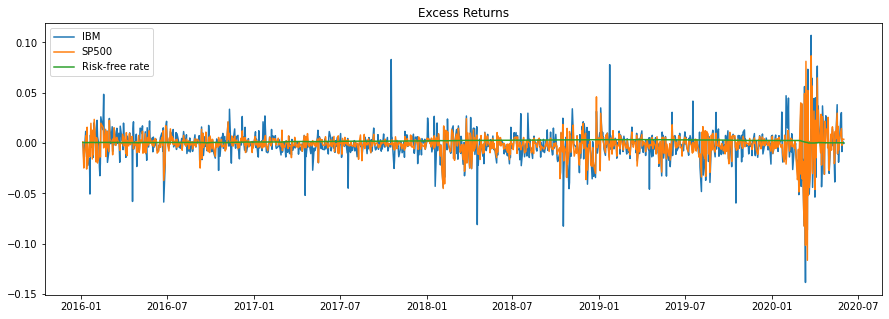

In [6]:
plt.figure(figsize=(15,5))
plt.title("Excess Returns")
x = plt.plot(final_returns);
plt.legend(iter(x), final_returns.columns);

In [7]:
model = pf.DynReg(f'{company} ~ SP500', data=final_returns)

Dynamic Linear Regression                                                                                 
======================================================= ==================================================
Dependent Variable: IBM                                 Method: MLE                                       
Start Date: 2016-01-05 00:00:00                         Log Likelihood: 3398.2694                         
End Date: 2020-06-01 00:00:00                           AIC: -6790.5389                                   
Number of observations: 1102                            BIC: -6775.5242                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.0001                                                           
Sigma^2 1                            

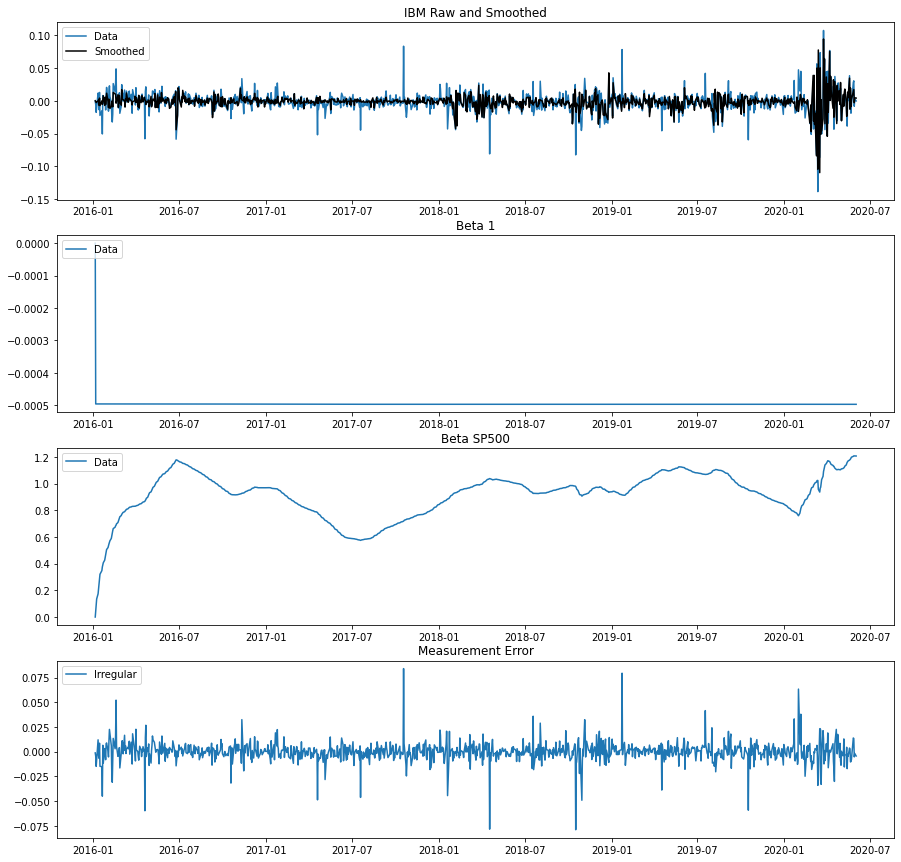

In [9]:
x_mle = model.fit()
x_mle.summary()
model.plot_fit(figsize=(15,15))